# Some analysis of the Swedish archive of conscripts

Data from https://ckan.oppnadata.se/dataset/insark-inskrivningsarkivregistret


In [1]:
import os.path
import numpy as np
import time
from scipy.stats import norm

import matplotlib.pyplot as plt
%matplotlib inline

Processing the data

In [2]:
#ESIM	STRING	Ej simkunnig
#LASV	STRING	Läs-skrivsvårighet. 1=läs och skrivsvårigheter. F r o m 1984.
#PENR	STRING	Personnummer
#INST	STRING	Inställelsedatum
#PPRF_BEFL	STRING	Befälslämplighet
#LNGD	STRING	Längd i cm
#MASS	STRING	Vikt i kg
codes_to_read = ['ESIM', 'LASV', 'PENR', 'INST', 'PPRF_BEFL', 'LNGD', 'MASS']

INSARK_DB = "insark_db.npz"
if os.path.exists(INSARK_DB):
    print("Found save file")
    print("Loading data...", end="")
    data = np.load(INSARK_DB)
    print("done")
else:
    print("Loading and processing INSARK data...", end="")
    t = time.time()
    data = {}
    for code in codes_to_read:
        data[code] = list()
    def to_int(d):
        try:
            if len(d)>0:
                return int(d)
        except:
            pass
        return None
    with open("INSARK.csv") as datafile:
        codes = datafile.readline().split('\t')
        codes[-1] = codes[-1].strip('\n')
        for linenumber, textline in enumerate(datafile):
            #print(textline)
            split_line = textline.split('\t')
            for code in codes_to_read:
                d = split_line[codes.index(code)].strip()
                if code in ['LNGD', 'MASS', 'ESIM', 'LASV', 'PPRF_BEFL', 'INST']:
                    d = to_int(d)
                data[code].append(d)
            #if linenumber > 100000:
            #    break
    # Clean up the data
    data['PENR'] = [to_int(e[:4]) for e in data['PENR']]
    mask = [data['LNGD'][i] is not None and data['MASS'][i] is not None for i in range(len(data['LNGD']))]
    mask = [mask[i] and data['LNGD'][i]>0 and data['MASS'][i]>0 for i in range(len(mask))]
    mask = [mask[i] and data['PENR'][i] is not None for i in range(len(mask))]
    for code in codes_to_read:
        data[code] = [e for i, e in enumerate(data[code]) if mask[i]]   
    data['LNGD'] = np.asarray(data['LNGD'], dtype=np.int)
    data['MASS'] = np.asarray(data['MASS'], dtype=np.int)
    data['PENR'] = np.asarray(data['PENR'], dtype=np.int)
    data['INST'] = np.asarray([0 if e is None else e for e in data['INST']], dtype=np.int)
    data['ESIM'] = np.asarray([0 if e is None else e for e in data['ESIM']], dtype=np.bool)
    data['LASV'] = np.asarray([0 if e is None else e for e in data['LASV']], dtype=np.bool)
    data['PPRF_BEFL'] = np.asarray([-1 if e is None else e for e in data['PPRF_BEFL']], dtype=np.int)

    np.savez_compressed(INSARK_DB, **data)
    print("done (%.1fs)" % (time.time()-t))

Found save file
Loading data...done


Some of the loaded numbers look weird. By removing outliers in the different categories we get nicer data. The drawback is that we get biased data. However, the examples here are about the general trends in the data so this error from bias is ok.

In [3]:
height = data['LNGD']
weight = data['MASS']
born = data['PENR']//100

mask = np.percentile(weight, .1) < weight
mask *= weight < np.percentile(weight, 99.9)
mask *= np.percentile(height, .1) < height
mask *= height < np.percentile(height, 99.9)

print("Removing %.1f%% as outliers" % (100*(1 - np.sum(mask)/mask.shape[0])))

height = height[mask]
weight = weight[mask]
born = born[mask]

Removing 0.5% as outliers


Histograms of year of birth, length and weight can now be plotted together with a normal approximation of the distributions.

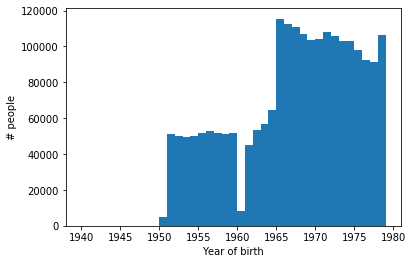

In [4]:
plt.figure()
plt.hist(born+1900, np.unique(born+1900))
plt.xlabel("Year of birth")
plt.ylabel("# people");
plt.show()

### Distribution over heights

The following tree histograms show the same data

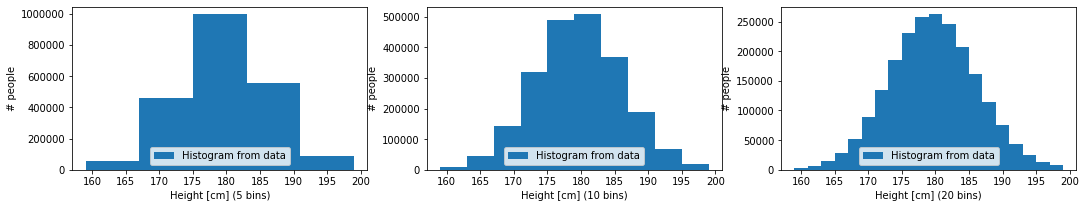

In [5]:
fig = plt.figure(figsize=(18, 3))
ax = fig.subplots(1, 3).ravel()
for bins, i in zip([5, 10, 20], range(3)):
    ax[i].hist(height, bins, label="Histogram from data")
    ax[i].set_xlabel("Height [cm] (%i bins)" % bins)
    ax[i].set_ylabel("# people")
    ax[i].legend(loc='lower center')
fig.show()

A better way is to fit a normal distribution to the data. This can be done by finding the mean and unbiased sample variance, or letting python do the work.

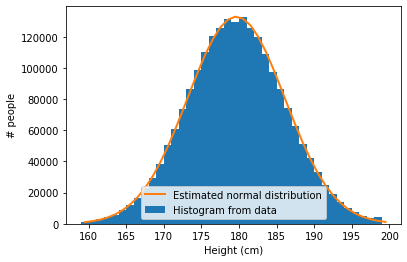

mu=179.1, sigma=6.5


In [6]:
d = norm(np.mean(height), np.std(height))

x = np.unique(height)
plt.figure()
h = plt.hist(height, x, label="Histogram from data")
plt.plot(x+.5, d.pdf(x)*len(height), label="Estimated normal distribution", linewidth=2)
plt.xlabel("Height (cm)")
plt.ylabel("# people")
plt.legend(loc='lower center')
plt.show()

print("mu=%.1f, sigma=%.1f" % (d.mean(), d.std()))

### Distribution over weights

Same as above

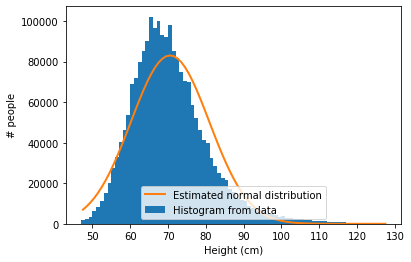

mu=70.1, sigma=10.4


In [7]:

d = norm(np.mean(weight), np.std(weight))
x = np.unique(weight)
plt.figure()
h = plt.hist(weight, x, label="Histogram from data")
plt.plot(x+.5, d.pdf(x)*len(weight), label="Estimated normal distribution", linewidth=2)
plt.xlabel("Height (cm)")
plt.ylabel("# people")
plt.legend(loc='lower center')
plt.show()

print("mu=%.1f, sigma=%.1f" % (d.mean(), d.std()))

The distribution of weights is a bit more complex than the very ideal distribution of the height data. It can, however, be described using two weighted normal distributions. This kind of model is called a Gaussian mixture model.

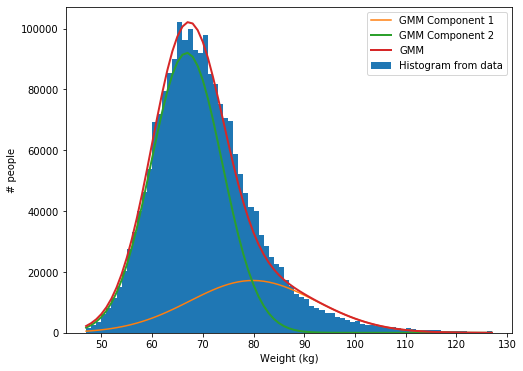

Gaussian mixture model (GMM):
w_1=0.2, mu_1=79.9, sigma_1=12.5
w_2=0.8, mu_2=66.8, sigma_2=7.0


In [8]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(np.vstack(np.random.choice(weight, size=100000)))
x = np.unique(weight)

plt.figure(figsize=(8, 6))
plt.hist(weight, x, label="Histogram from data")
plt.plot(x,
         (norm(gmm.means_[0], np.sqrt(gmm.covariances_[0])).pdf(x)*len(weight)*gmm.weights_[0]).ravel(),
         label="GMM Component 1")
plt.plot(x,
         (norm(gmm.means_[1],np.sqrt(gmm.covariances_[1])).pdf(x)*len(weight)*gmm.weights_[1]).ravel(),
         label="GMM Component 2", linewidth=2)
plt.plot(x, np.exp(gmm.score_samples(np.vstack(x)))*len(weight), label="GMM", linewidth=2)
plt.xlabel("Weight (kg)")
plt.ylabel("# people")
plt.legend(loc='upper right')
plt.show()

print("Gaussian mixture model (GMM):")
print("w_1=%.1f, mu_1=%.1f, sigma_1=%.1f" % (gmm.weights_[0], gmm.means_[0], np.sqrt(gmm.covariances_[0])))
print("w_2=%.1f, mu_2=%.1f, sigma_2=%.1f" % (gmm.weights_[1], gmm.means_[1], np.sqrt(gmm.covariances_[1])))


Let's see how the distribution over weights differ for differnent age groups.

Born in 50s: mu=68.0, sigma=9.6
Born in 60s: mu=69.9, sigma=10.1
Born in 70s: mu=71.2, sigma=10.8


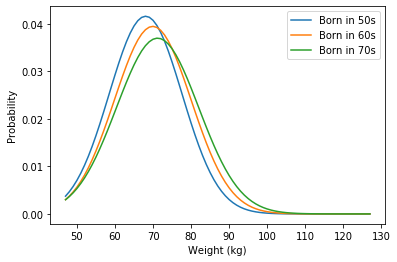

In [9]:
X = np.arange(10, 99, 10)
data = list()
for x in X:
    data.append(np.asarray([w for w, b in zip(weight, born) if x<=b and b<(x+10)]))

w = np.unique(weight)

plt.figure()
for d, x in zip(data, X):
    if len(d) > 10:
        n = norm(np.mean(d), np.std(d))
        plt.plot(w, n.pdf(w), label="Born in %is"%x)
        print("Born in %is: mu=%.1f, sigma=%.1f" % (x, n.mean(), n.std()))
plt.legend(loc='upper right')
plt.xlabel("Weight (kg)")
plt.ylabel("Probability")
plt.show()

### Correlation

The easiest way of getting to know your data is to visualize it in some way. Below, I use a scatter plot to show height and weight for a random subset of the data.

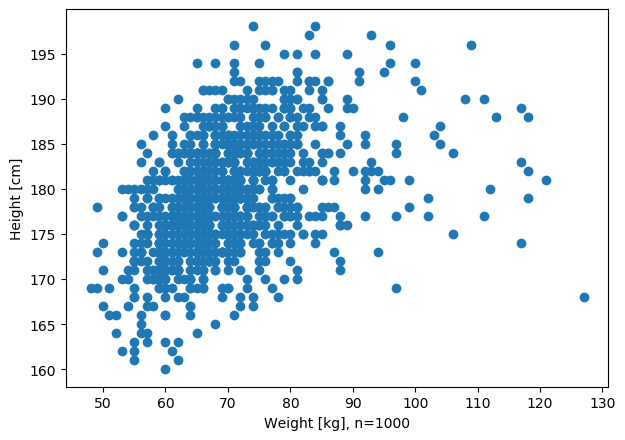

In [10]:
n_sample = 1000
m = np.random.choice(range(len(height)), n_sample, replace=False)

plt.figure(figsize=(7, 5), dpi=100)
plt.scatter(weight[m], height[m])
plt.xlabel("Weight [kg], n=%i" % n_sample)
plt.ylabel("Height [cm]")
plt.show()

The weight and height as 1D and 2D histograms 

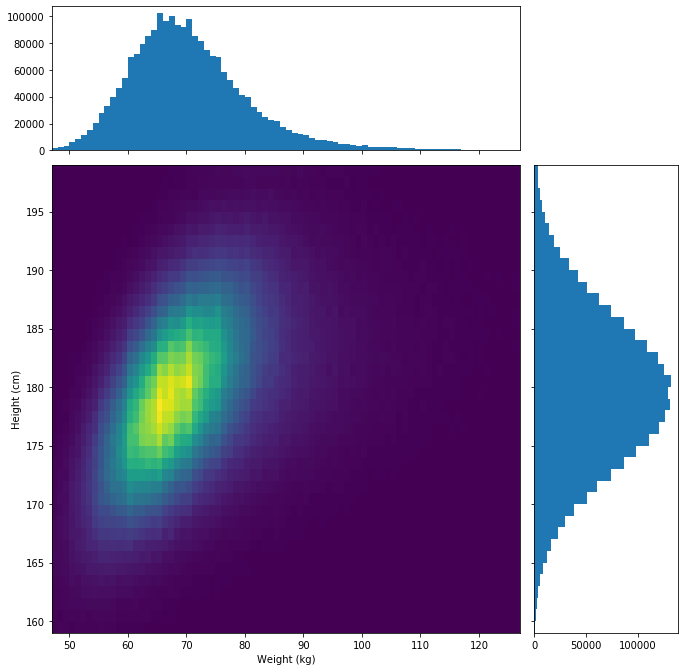

In [11]:
from matplotlib.ticker import NullFormatter

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.65
bottom, plotheight = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, plotheight]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, plotheight]

# start with a rectangular Figure
plt.figure(1, figsize=(10, 10))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)

# the scatter plot:
axScatter.hist2d(weight, height, [np.unique(weight), np.unique(height)])
axHistx.hist(weight, bins=np.unique(weight))
axHisty.hist(height, bins=np.unique(height), orientation='horizontal')

axHistx.set_xlim(axScatter.get_xlim())
axHisty.set_ylim(axScatter.get_ylim())

axScatter.set_xlabel("Weight (kg)")
axScatter.set_ylabel("Height (cm)")

plt.show()